In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
data1 = pd.read_csv('power_consumption_g3.csv')
data2 = pd.read_csv('power_consumption_g3_feat.csv')

In [4]:
data1 = data1.sort_values('Date')
data2 = data2.sort_values('Date')

In [5]:
data1['Date'] = pd.to_datetime(data1['Date'])
data2['Date'] = pd.to_datetime(data2['Date'])

In [7]:
df = data2.merge(data1,how='left', right_index=True, left_index=True)

In [32]:
data_resampled = df.resample('2h').mean().dropna()
data_resampled.reset_index(inplace=True)
data_resampled.head()

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower,SolarPower_lag_1,SolarPower_lag_2,SolarPower_lag_3,SolarPower_lag_4
0,2017-01-01 08:00:00,4.632167,73.791667,0.082417,79.281917,15.761833,21255.189872,20094.683545,20641.518987,21447.088607,26927.594937
1,2017-01-01 10:00:00,8.019333,63.835833,2.913333,346.072727,34.108333,27986.835442,21255.189872,20094.683545,20641.518987,21447.088607
2,2017-01-01 12:00:00,15.263333,57.075000,0.076167,486.391667,40.981667,30060.759495,27986.835442,21255.189872,20094.683545,20641.518987
3,2017-01-01 14:00:00,15.662500,56.914167,0.075667,377.458333,48.125000,29558.481012,30060.759495,27986.835442,21255.189872,20094.683545
4,2017-01-01 16:00:00,15.309167,59.112500,0.077250,160.075833,169.773333,31576.708860,29558.481012,30060.759495,27986.835442,21255.189872


In [33]:
n_lags = 4
for lag in range (1, n_lags +1):
    data_resampled[f'SolarPower_lag_{lag}'] = data_resampled['SolarPower'].shift(lag)

data_lagged = data_resampled.dropna()
data_lagged

,Date,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,SolarPower,SolarPower_lag_1,SolarPower_lag_2,SolarPower_lag_3,SolarPower_lag_4
4,2017-01-01 16:00:00,15.309167,59.112500,0.077250,160.075833,169.773333,31576.708860,29558.481012,30060.759495,27986.835442,21255.189872
5,2017-01-01 18:00:00,12.911667,67.740833,0.077417,2.432750,2.487417,39969.113924,31576.708860,29558.481012,30060.759495,27986.835442
6,2017-01-01 20:00:00,11.729091,70.855000,0.076250,0.060333,0.097083,39542.278480,39969.113924,31576.708860,29558.481012,30060.759495
7,2017-01-01 22:00:00,12.251667,69.361000,0.074667,0.066333,0.108333,32522.531644,39542.278480,39969.113924,31576.708860,29558.481012
8,2017-01-02 00:00:00,10.685000,78.475000,0.076417,0.068583,0.139583,23907.848100,32522.531644,39542.278480,39969.113924,31576.708860
...,...,...,...,...,...,...,...,...,...,...,...
4355,2017-12-30 14:00:00,14.513333,39.486364,0.077667,409.650000,42.163333,29293.789606,30490.240812,29649.683142,23720.152091,21307.984791
4356,2017-12-30 16:00:00,14.015000,43.236364,0.077500,153.905000,152.368333,31262.864386,29293.789606,30490.240812,29649.683142,23720.152091
4357,2017-12-30 18:00:00,10.112500,60.239091,0.075583,1.618917,1.676750,37721.673005,31262.864386,29293.789606,30490.240812,29649.683142
4358,2017-12-30 20:00:00,8.526667,66.832500,0.080917,0.062917,0.101667,36183.523447,37721.673005,31262.864386,29293.789606,30490.240812


In [34]:
features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'SolarPower_lag_1', 'SolarPower_lag_2', 'SolarPower_lag_3', 'SolarPower_lag_4']

In [35]:
data_lagged.isnull().sum()

Date                   0
Temperature            0
Humidity               0
WindSpeed              0
GeneralDiffuseFlows    0
DiffuseFlows           0
SolarPower             0
SolarPower_lag_1       0
SolarPower_lag_2       0
SolarPower_lag_3       0
SolarPower_lag_4       0
dtype: int64

In [36]:
X = data_lagged[features]
Y = data_lagged['SolarPower']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)

In [37]:
model = XGBRegressor()

In [38]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [39]:
param_grid={
    'n_estimators':[50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate':[0.01, 0.1, 0.05]
}

In [40]:
rkf = RepeatedKFold(n_splits=5)
rkf.get_n_splits(X, Y)

50

In [41]:
cv = GridSearchCV(estimator=model,param_grid=param_grid,cv=rkf)

In [42]:
cv.fit(X_train, Y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.05],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150]})

In [43]:
best_model = cv.best_estimator_

Y_pred = best_model.predict(X_test)

In [44]:
r2_score(Y_test, Y_pred)

0.8779917534235939

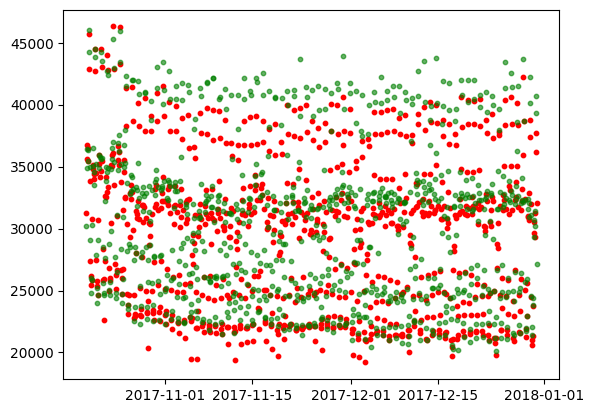

In [50]:
plt.scatter(data_lagged['Date'][-len(Y_test):], Y_test.values, color='red', label='Actual', s=10)
plt.scatter(data_lagged['Date'][-len(Y_test):], Y_pred, color='green', label='Predicted', s=10, alpha=0.6)